# Visualize Simulated Boycott Results

In [796]:
from collections import defaultdict, OrderedDict
import json

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="darkgrid")
from scipy import stats

from scipy.interpolate import interp1d

sns.set_color_codes("dark")

# http://files.grouplens.org/datasets/movielens/ml-1m-README.txt
NUM_USERS = 6040
NUM_RATINGS = 1000209

In [797]:
NORMALIZE = True

First things first: let's load our master data file (a single, aggregated csv)
and take a glance at the data.

In [798]:
# old_df = pd.read_csv('all_results_v01.csv', dtype={'indices': str})
df = pd.read_csv('all_results.csv', dtype={'indices': str})
print(len(df.index))
df = df[df.ratingfrac.notna()]

print(len(df.index))

13786
10856


Let's apply transformation that will affect the entire dataframe.
1. Calculate the number of users included in each experiment.

In [799]:
df = df.assign(num_users_boycotting = [(NUM_USERS - int(x))/NUM_USERS for x in df.num_users])
df = df.assign(num_ratings_missing = [NUM_RATINGS - int(x) for x in df.num_ratings])
df = df.assign(nrm_rounded = [round(x, -5) for x in df.num_ratings_missing])
# df = df.assign(user_boycott_frac = [x / NUM_USERS for x in df.num_users_boycotting])


# drop columns we're not going to use.
drops = [
    #'tail',
]
for column in df.columns.values:
    for drop in drops:
        if drop in column:
            df = df.drop(column, axis=1)

# old_df = old_df.assign(num_users_boycotting = [NUM_USERS - int(x) for x in old_df.num_users])

Define all the lists that can be used throughout. By editing this cell we can easily modify the full notebook.

In [800]:
id_vars = ['name','algo_name', 'indices', 'ratingfrac', 'userfrac', 'num_ratings', 'num_users', 'num_users_boycotting']
id_vars = [x for x in id_vars if x in list(df.columns.values)]
metrics = [
    # 'rmse',
    'ndcg10',
    'tailndcg10',
    # 'ndcg5',
    # 'tailndcg5',
    # 'ndcgfull',
    # 'tailndcgfull',
    # 'ndcgfull',
    'prec10t4',
    'tailprec10t4',
    # 'prec5t4',
    # 'tailprec5t4',
]

metrics2 = [
    'prec10t4', 'tailprec10t4'
]

groups = [
    'non-boycott', 
    'like-boycott'
]

organized_experiments = [
    'gender', 'age', 'state',
    'occupation', 'power', 'genre',
    'genre_strict',
]
algo_names = [
    'KNNBaseline_item_msd',
    'SVD'
]
standard_algo_names = [
    'KNNBaseline_item_msd', 'SVD', 'GlobalMean', 'MovieMean', 'GuessThree',
    'KNNBasic_user_msd']
standard_results = {}
algo_to_metric_vs_global_mean = defaultdict(dict)
algo_to_metric_vs_movie_mean = defaultdict(dict)
algo_to_metric_vs_guess_three = defaultdict(dict)
algo_to_metric_vs_knn = defaultdict(dict)
algo_to_metric_vs_user = defaultdict(dict)

for algo_name in standard_algo_names:
    try:
        filename_ratingcv_standards = 'standard_results/{}_ratingcv_standards_for_{}_10.json'.format(
            'ml-1m', algo_name)
        with open(filename_ratingcv_standards, 'r') as f:
            standard_results[algo_name] = json.load(f)
    except:
        filename_ratingcv_standards = 'standard_results/{}_ratingcv_standards_for_{}.json'.format(
            'ml-1m', algo_name)
        with open(filename_ratingcv_standards, 'r') as f:
            standard_results[algo_name] = json.load(f)
for main_algo_name in algo_names:
    for metric in metrics:
        goodval = standard_results[main_algo_name].get(metric, 0)
        print('goodval', goodval)
        gmean = standard_results['GlobalMean'][metric]
        mmean = standard_results['MovieMean'].get(metric, 0)
        guess_three = standard_results['GuessThree'][metric]
        knn = standard_results['KNNBaseline_item_msd'][metric]
        userval = standard_results['KNNBasic_user_msd'][metric]
        
        algo_to_metric_vs_global_mean[main_algo_name][metric] = (gmean - goodval) / goodval * 100 if goodval else 0
        algo_to_metric_vs_movie_mean[main_algo_name][metric] = (mmean - goodval) / goodval * 100 if goodval else 0
        algo_to_metric_vs_guess_three[main_algo_name][metric] = (guess_three - goodval) / goodval * 100 if goodval else 0
        algo_to_metric_vs_knn[main_algo_name][metric] = (knn - goodval) / goodval * 100 if goodval else 0
        algo_to_metric_vs_user[main_algo_name][metric] = (userval - goodval) / goodval * 100 if goodval else 0

print(algo_to_metric_vs_user)
print('movie', algo_to_metric_vs_movie_mean)
print('standards', standard_results['SVD'])

goodval 0.7915010747294138
goodval 0.7709071131113574
goodval 0.7996180529706427
goodval 0.7550357420547575
goodval 0.7932274802085224
goodval 0.7726320157124156
goodval 0.8035308395114538
goodval 0.7583377317033532
defaultdict(<class 'dict'>, {'KNNBaseline_item_msd': {'ndcg10': -1.5297336566628477, 'tailndcg10': -0.6288588325065513, 'prec10t4': -0.9195055145906519, 'tailprec10t4': -0.2880358653856256}, 'SVD': {'ndcg10': -1.7440474715343823, 'tailndcg10': -0.850705114286477, 'prec10t4': -1.4019771338692901, 'tailprec10t4': -0.7222063670618238}})
movie defaultdict(<class 'dict'>, {'KNNBaseline_item_msd': {'ndcg10': -2.28498443923114, 'tailndcg10': -1.8801368989417346, 'prec10t4': -1.7771582229651413, 'tailprec10t4': -1.3424905227809054}, 'SVD': {'ndcg10': -2.4976545023143673, 'tailndcg10': -2.0991896998050676, 'prec10t4': -2.25545350972609, 'tailprec10t4': -1.772069668629652}})
standards {'mae': 0.685967676749731, 'ndcg10': 0.7932274802085224, 'ndcg10_frac': 0.7248356015942885, 'ndcg10_

In [801]:
0.803556166616451 - (0.803556166616451 * (1 - 0.004889779445720951))

0.003929212427003503

In [802]:
algo_to_metric_to_slope = defaultdict(dict)
algo_to_metric_to_intercept = defaultdict(dict)
algo_to_metric_to_average_boycott = defaultdict(dict)

In [803]:
samples_df = df[df['type'] == 'sample_users']
if not samples_df.empty:
    print(samples_df[['name', 'num_users', 'num_users_boycotting']].head())
org_df = df[df['type'].isin(organized_experiments)]

                  name  num_users  num_users_boycotting
3536  1208 user sample       4832                   0.2
3538  1208 user sample       4832                   0.2
3539  1208 user sample       4832                   0.2
3541  1208 user sample       4832                   0.2
3542  1208 user sample       4832                   0.2


In [804]:
org_df.name = [
    x.replace('excluded', '')
    .replace('users from', '')
    .replace('US_', '')
    .replace('state', '')
    .strip()
    for x in list(org_df.name)
]

C:\Users\Nick\Anaconda3\lib\site-packages\pandas\core\generic.py:3643: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


First, let's see how well the # of ratings correlates with error.
This will be an important piece of context for analyzing the experiments.

In [805]:
# for algo_name in algo_names:
#     filt = org_df[org_df.algo_name == algo_name]
#     for metric in metrics:
#         key = 'percent_increase_{}_non-boycott'.format(metric)
#         sns.jointplot(filt.num_ratings, y=filt[key], kind="reg").fig.suptitle(algo_name)
#         plt.show()
#         slope, intercept, r_value, p_value, std_err = stats.linregress(filt.num_ratings, y=filt[key])
#         print(slope, intercept, r_value, p_value)
#         algo_to_metric_to_slope[algo_name][metric] = slope
#         algo_to_metric_to_intercept[algo_name][metric] = intercept
        
#         # calculate the average error for all boycott users in each dataframe
#         algo_to_metric_to_average_boycott[algo_name][metric] = np.mean(
#             samples_df[(
#                 (samples_df.algo_name == algo_name) &
#                 (samples_df.userfrac == 1.0) & 
#                 (samples_df.ratingfrac == 1.0)
#             )][key.replace('non-boycott', 'boycott')]
#         )

In [806]:
def select_cols(cols, metrics, groups, percents):
    """take a list of cols and filter based on metrics/groups/percents"""
    increase_cols = [
        x for x in cols if (any(metric in x for metric in metrics) and 'increase' in x)
    ]
    increase_cols = [
        x for x in increase_cols if any(group == x.split('_')[-1] for group in groups)
    ]
    if percents:
        increase_cols = [x for x in increase_cols if 'percent' in x]
    else:
        increase_cols = [x for x in increase_cols if 'percent' not in x]
    return increase_cols

In [807]:
def fill_in_longform(df):
    """Fill in a longform dataframe with metric, group, and name information"""
    df = df.assign(
        metric=[x.split('_')[-2] for x in df.increase_type]
    )
    df = df.assign(
        group=[x.split('_')[-1] for x in df.increase_type]
    )
    return df
    

In [808]:
palette={'all': 'b', 'non-boycott': 'g'}

In [809]:
def p_b_curve(
        df, metrics, groups, percents=False, lm_plot=True,
        reg_plot=False, hue='group', row='metric',
    ):
    # so we can modify without fear
    df = df.copy()
    algo_to_metric_to_group_to = defaultdict(lambda: defaultdict(lambda: defaultdict(dict)))

    increase_cols = select_cols(list(df.columns.values), metrics, groups, percents)
    increase_cols = [x for x in increase_cols if 'vanilla' not in x]
    if NORMALIZE:
        for metric in metrics:
            for algo_name in algo_names:
                movie_val = abs(algo_to_metric_vs_movie_mean[algo_name][metric])
                for increase_col in increase_cols:
                    if increase_col.split('_')[-2] == metric:
                        df.loc[df.algo_name == algo_name, increase_col] /= movie_val
    print('Selected increase_cols are:')
    print(increase_cols)
    
    if lm_plot:
        longform = df[increase_cols + id_vars].melt(
            id_vars = id_vars,
            var_name='increase_type'
        )
        longform = fill_in_longform(longform)
        
        #xticklabels = [x/NUM_USERS for x in sorted(list(set(longform.num_users_boycotting)))]

        grid = sns.lmplot(
            x="num_users_boycotting", y="value", hue=hue, data=longform,
            sharey='row', sharex='col',
            size=10, row=row, col='algo_name',
            fit_reg=False,
            x_estimator=np.mean, ci=99,
            palette=palette,
        )
        if NORMALIZE:
            grid.set(ylim=(-1.5, 0.1))

    algo_to_size_to_decreases = defaultdict(lambda: defaultdict(list))
    for metric in metrics:
        for algo_name in algo_names:
            filt = df[df.algo_name == algo_name]
            for group in groups:
                key = 'increase_{}_{}'.format(metric, group)
                if percents:
                    key = 'percent_' + key
                x = filt.num_users_boycotting
                user_nums = sorted(list(set(filt.num_users_boycotting)))
                nrm_rounded = sorted(list(set(filt.nrm_rounded)))
                y = filt[key]

                num_to_mean = OrderedDict()
                for num_users_boycotting in user_nums:
                    filt_by_name = filt[filt.num_users_boycotting == num_users_boycotting]
                    # print('1', len(filt_by_name[key]))
                    num_to_mean[num_users_boycotting] = np.mean(filt_by_name[key])
                nrm_rounded_to_mean = OrderedDict()
                for num in nrm_rounded:
                    filt_by_nrm = filt[filt.nrm_rounded == num]
                    nrm_rounded_to_mean[num] = np.mean(filt_by_nrm[key])

                if group == 'non-boycott':
                    for num in [
                        #1, 3, 
                        # 604, 1812
                        0.1, 0.3,
                    ]:
                        val_nb = num_to_mean[num]
                        val_all = np.mean(filt[filt.num_users_boycotting == num][key.replace('non-boycott', 'all')])
                        ratio_nb = val_nb / algo_to_metric_vs_movie_mean[algo_name][metric]
                        ratio_all = val_all / algo_to_metric_vs_movie_mean[algo_name][metric]
                        if metric == 'ndcg10':
                            print('***')
                        print(
                            'Algo:{}  |  Metric:{}  |  #users:{}'.format(
                                algo_name, metric, num, 
                            )
                        )
                        print('NB Val:{}  |  NB Ratio:{}'.format(
                            val_nb,
                            ratio_nb
                        ))
                        print('all Val:{}  |  all Ratio:{}'.format(
                            val_all,
                            ratio_all,
                        ))
                        algo_to_size_to_decreases[algo_name][num].append(ratio_nb)
                meany = np.array(list(num_to_mean.values()))
                meany_ratings = np.array(list(nrm_rounded_to_mean.values()))

                algo_to_metric_to_group_to[algo_name][metric][group]['x'] = user_nums
                algo_to_metric_to_group_to[algo_name][metric][group]['y'] = meany

                #smoothf = interp1d(user_nums, meany, kind='linear', bounds_error=False, fill_value='extrapolate')
                smoothf_ratings = interp1d(nrm_rounded, meany_ratings, kind='linear', bounds_error=False, fill_value='extrapolate')

                #algo_to_metric_to_group_to[algo_name][metric][group]['interp'] = smoothf
                algo_to_metric_to_group_to[algo_name][metric][group]['interp_ratings'] = smoothf_ratings

                algo_to_metric_to_group_to[algo_name][metric][group]['max_user_units'] = max(user_nums)
                xnew = np.linspace(min(user_nums), max(user_nums), num=1000)
                algo_to_metric_to_group_to[algo_name][metric][group]['xnew_ratings'] = np.linspace(
                    min(filt.num_ratings_missing), max(filt.num_ratings_missing), num=1000)

    for x in grid.facet_data():
        i_row, i_col, i_hue = x[0]
        metric = grid.row_names[i_row]
        algo_name = grid.col_names[i_col]
        group = grid.hue_names[i_hue]
        
        zero_line = 0
        movie_val = abs(algo_to_metric_vs_movie_mean[algo_name][metric])
        itemitem_line = algo_to_metric_vs_knn[algo_name][metric]
        useruser_line = algo_to_metric_vs_user[algo_name][metric]
        movie_val = -1 * algo_to_metric_vs_movie_mean[algo_name][metric]
        movie_line = algo_to_metric_vs_movie_mean[algo_name][metric]
        if NORMALIZE:
            itemitem_line /= movie_val
            useruser_line /= movie_val
            movie_line /= movie_val
        
        ax = grid.axes[i_row, i_col]
#         print(algo_to_metric_to_group_to[algo_name][metric][group]['x'])
#         print(algo_to_metric_to_group_to[algo_name][metric][group]['y'])
        ax.plot(
            algo_to_metric_to_group_to[algo_name][metric][group]['x'],
            algo_to_metric_to_group_to[algo_name][metric][group]['y'],
            linestyle='-', color=grid._colors[i_hue]
        )
        xnew_ratings = algo_to_metric_to_group_to[algo_name][metric][group]['xnew_ratings']
        #ynew = algo_to_metric_to_group_to[algo_name][metric][group]['interp'](xnew)
        ynew_ratings = algo_to_metric_to_group_to[algo_name][metric][group]['interp_ratings'](xnew_ratings)
        
        ax.plot(
            xnew_ratings * algo_to_metric_to_group_to[algo_name][metric][group]['max_user_units'] / NUM_RATINGS,
            ynew_ratings, '-')
        ax.axhline(0, color='0.5', linestyle=':')
        ax.axhline(movie_line, color='0.5', linestyle=':')
        plt.setp(ax.get_xticklabels(), visible=True, rotation=45)
        if algo_name == 'SVD':
            ax.axhline(itemitem_line, color='0.1', linestyle=':')
            ax.axhline(useruser_line, color='0.1', linestyle=':')
    plt.subplots_adjust(hspace=0.2)
#     for metric in metrics:
#         for algo_name in algo_names
    algo_to_size_to_mean_dec = defaultdict(dict)
    for algo_name, size2dec in algo_to_size_to_decreases.items():
        for size, decs in size2dec.items():
            algo_to_size_to_mean_dec[algo_name][size] = np.mean(decs)
    print('=====\nSize to Mean Decrease')
    print(algo_to_size_to_mean_dec)
    #grid.map(plt.mean, "num_users_boycotting", "value", marker="o", ms=4)
    return algo_to_metric_to_group_to

Selected increase_cols are:
['percent_increase_ndcg10_all', 'percent_increase_ndcg10_non-boycott', 'percent_increase_prec10t4_all', 'percent_increase_prec10t4_non-boycott', 'percent_increase_tailndcg10_all', 'percent_increase_tailndcg10_non-boycott', 'percent_increase_tailprec10t4_all', 'percent_increase_tailprec10t4_non-boycott']
***
Algo:KNNBaseline_item_msd  |  Metric:ndcg10  |  #users:0.1
NB Val:-0.006412235562803749  |  NB Ratio:0.0028062491160602224
all Val:-0.1024182460351003  |  all Ratio:0.044822294750314524
***
Algo:KNNBaseline_item_msd  |  Metric:ndcg10  |  #users:0.3
NB Val:-0.10048117767709636  |  NB Ratio:0.04397455665427054
all Val:-0.3668583964712449  |  all Ratio:0.16055181390849504
***
Algo:SVD  |  Metric:ndcg10  |  #users:0.1
NB Val:-0.05341757511676516  |  NB Ratio:0.02138709539981113
all Val:-0.15936387921237938  |  all Ratio:0.0638054138651724
***
Algo:SVD  |  Metric:ndcg10  |  #users:0.3
NB Val:-0.2111139533889756  |  NB Ratio:0.08452488252212384
all Val:-0.47669

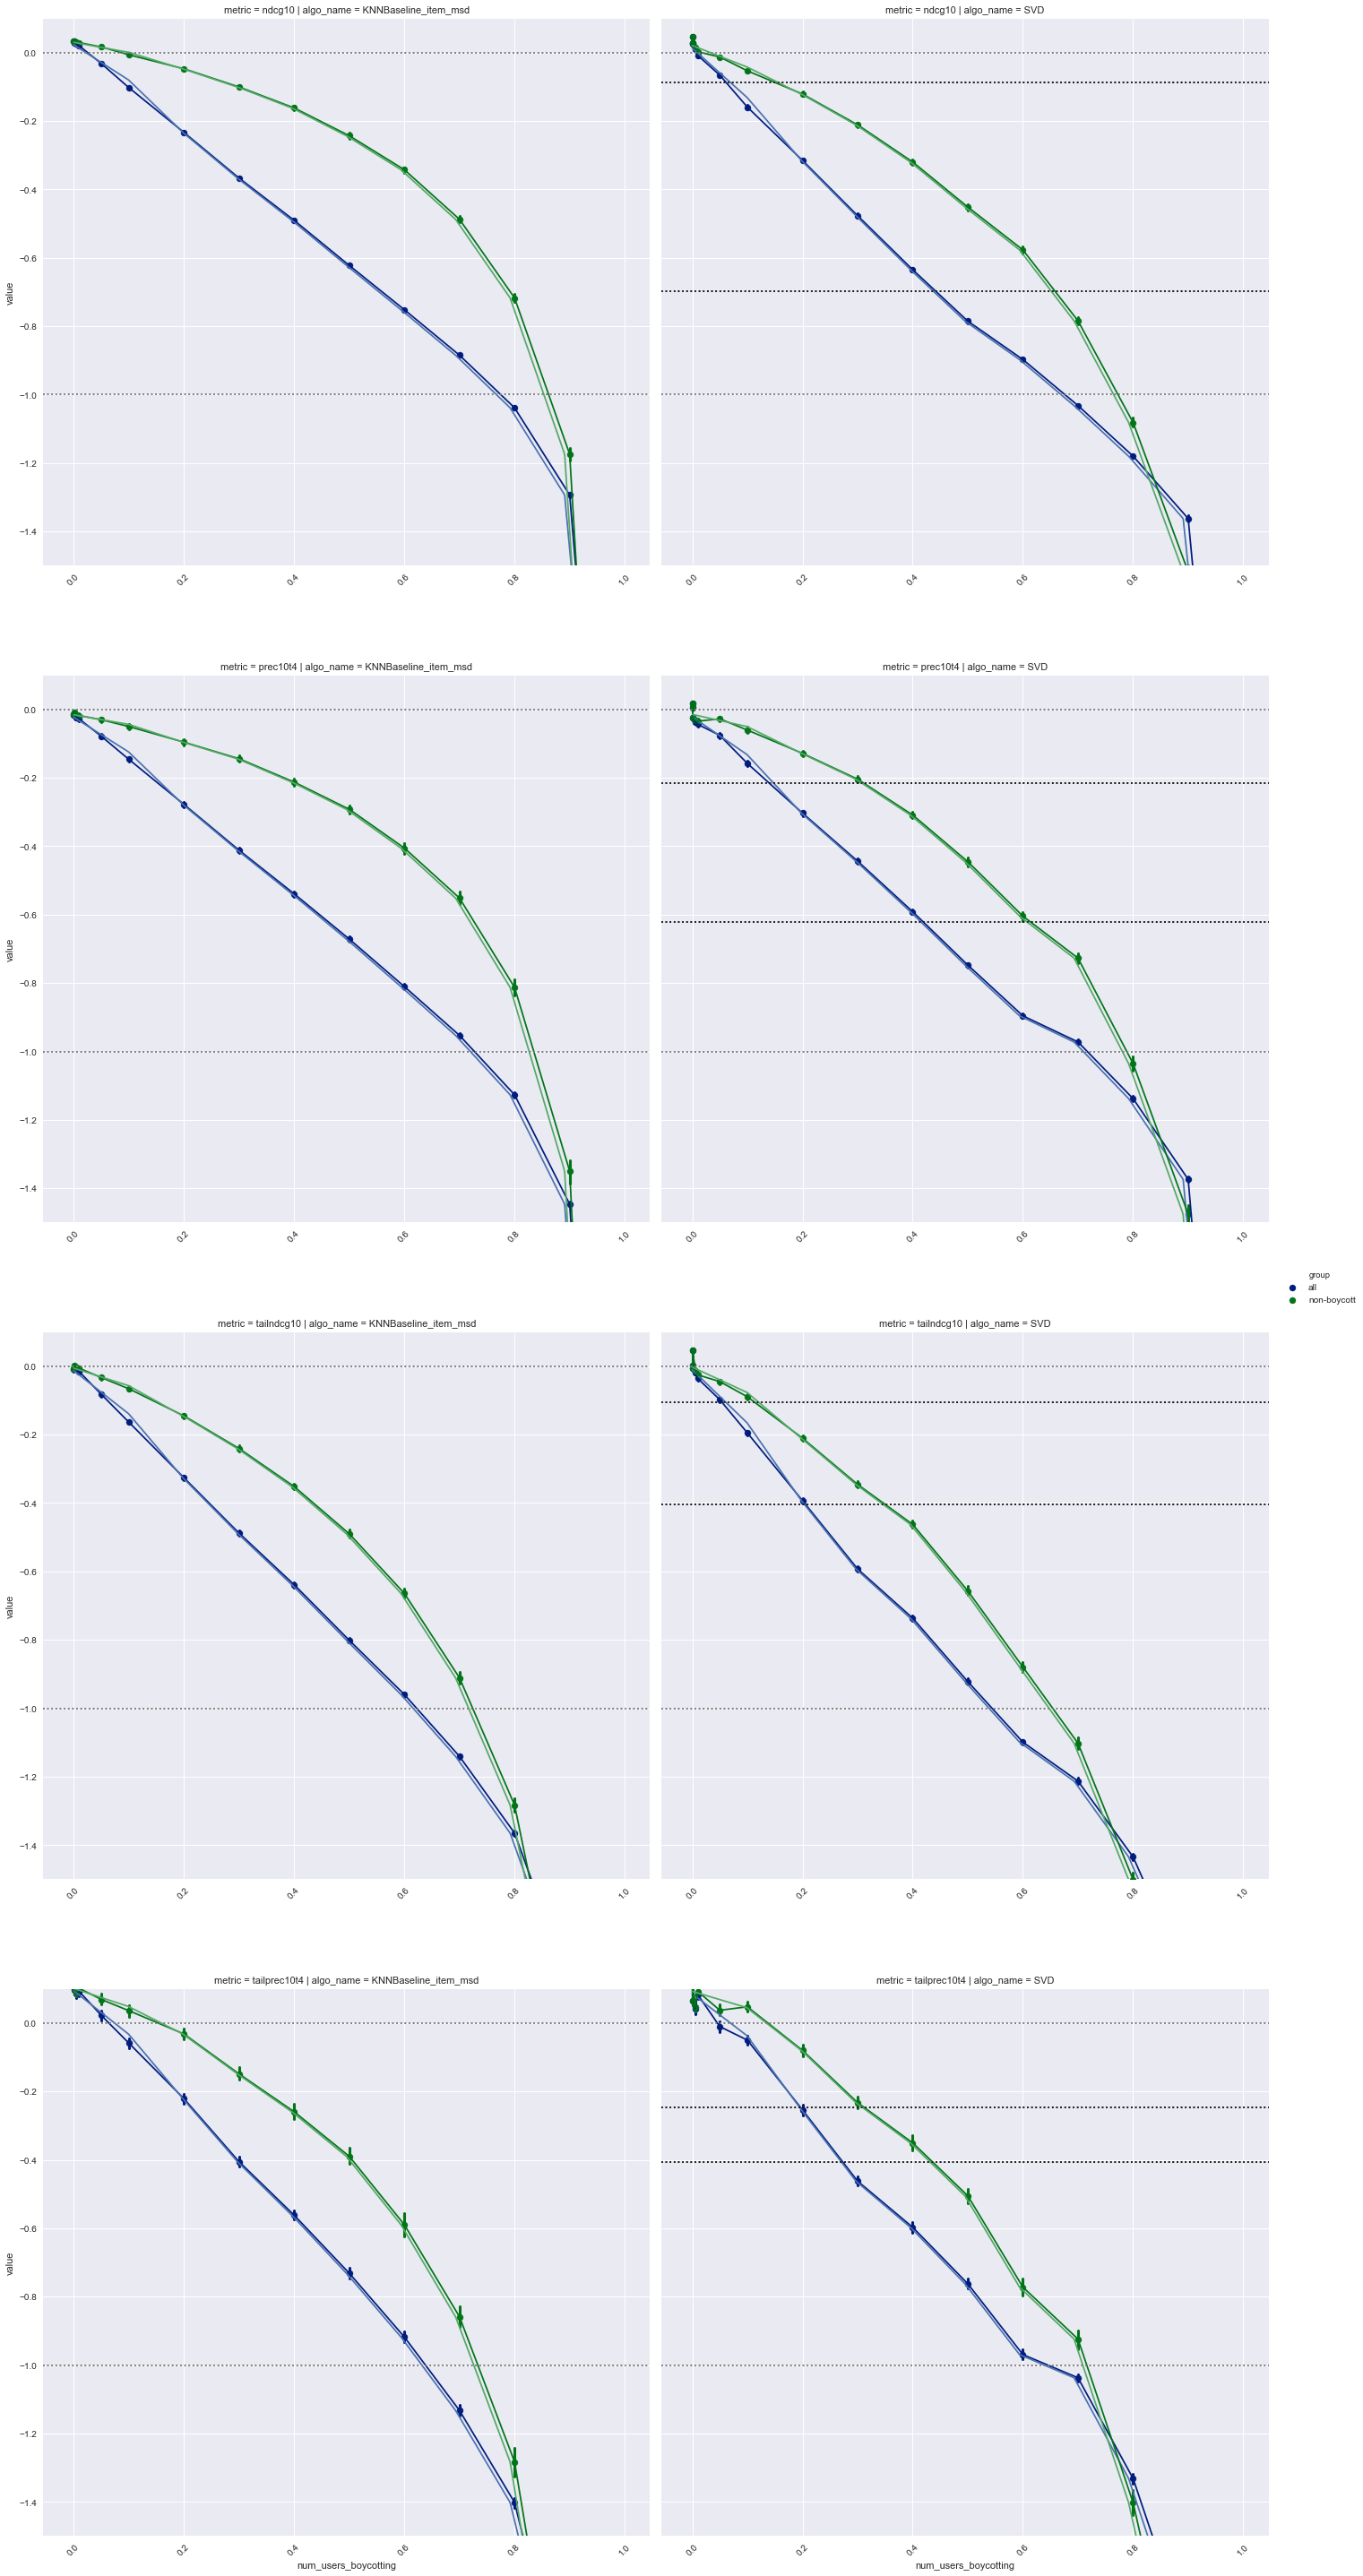

In [810]:
algo_to_metric_to_group_to = p_b_curve(
    samples_df,
    metrics=metrics,
    percents=True,
    groups=['non-boycott', 'all', ],
)
plt.show()

In [811]:
# p_b_curve(
#     samples_df,
#     metrics=metrics2,
#     percents=True,
#     groups=['non-boycott', ],
#     hue='metric',
#     row='group',
# )
# plt.show()

In [812]:
normed_org_df = org_df.copy()
for metric in metrics:
    for algo_name in algo_names:
        movie_val = abs(algo_to_metric_vs_movie_mean[algo_name][metric])
        for group in groups:
            col = 'percent_increase_{}_{}'.format(metric, group)
            normed_org_df.loc[
                normed_org_df.algo_name == algo_name, col
            ] = org_df.loc[org_df.algo_name == algo_name, col] / movie_val
            if group == 'non-boycott':
                key = col.replace('non-boycott', 'expected')
                expected_vals = algo_to_metric_to_group_to[algo_name][metric][group]['interp_ratings'](normed_org_df.num_ratings_missing)
                kwargs = {key: expected_vals}
                normed_org_df = normed_org_df.assign(**kwargs)

In [813]:
def plot2(df, metrics, groups, percents=False, kind='bar', size=10):
    print('len', len(df.index))
    print(df.num_ratings_missing)
    increase_cols = select_cols(list(df.columns.values), metrics, groups, percents)
    increase_cols = [x for x in increase_cols if 'vanilla' not in x]
    longform = df[increase_cols + id_vars].melt(
        id_vars = id_vars,
        var_name='increase_type'
    )
    longform = fill_in_longform(longform)
    longform = longform.assign(
        name_plus_ratings=['{} ({}k)'.format(
            name, int(round(num_ratings/1000,0))
        ) for name, num_ratings in zip(longform.name, longform.num_ratings)
    ])
    grid = sns.factorplot(
        x="value", y="name", hue="group", data=longform,
        size=size, kind=kind, col='algo_name', row='metric',
        sharex=False,
        row_order=metrics,
        # linestyles='None',
        # capsize=0.1
    )
    a = grid.axes
    
    for metric in metrics:
        for col in increase_cols:
            if metric in col and 'expected' in col:
                expec = col
    
    total = 0
    total_sig = 0
    total_less = 0
    total_more = 0
    for x in grid.facet_data():
        i_row, i_col, i_hue = x[0]
        metric = grid.row_names[i_row]
        algo_name = grid.col_names[i_col]
        if grid.hue_names:
            group = grid.hue_names[i_hue]
        val = algo_to_metric_vs_movie_mean[algo_name].get(metric, 0)
        grid.axes[i_row, i_col].axvline(0, color='0.5', linestyle='--')
        if NORMALIZE:
            movie_val = abs(algo_to_metric_vs_movie_mean[algo_name][metric])
            val /= movie_val
        grid.axes[i_row, i_col].axvline(val, color='0.5', linestyle='--')
        
        for col in increase_cols:
            if metric == col.split('_')[-2]:
                if 'expected' in col:
                    expec = col
                elif 'non-boycott' in col:
                    nb = col
        for name in list(set(longform.name)):
            mask = (
                (longform.metric == metric) &
                (longform.algo_name == algo_name) &
                (longform.name == name)
            )
            
            masked = longform[mask]
            try:
                expec_arr = np.array(masked[masked.increase_type == expec].value)
                nb_arr = np.array(masked[masked.increase_type == nb].value)
                
                expec_mean = np.mean(expec_arr)
                nb_mean = np.mean(nb_arr)
                # TODO
                ratio = np.mean(nb_arr)/np.mean(expec_arr)
                pval = stats.ttest_ind(expec_arr, nb_arr, equal_var=False).pvalue
                
                total += 1
                if pval < 0.05:
                    print('**')
                    print('{} {} {}, {}, {}'.format(metric, algo_name, name, expec, nb))
                    print('Ratio: {}, pval: {}'.format(ratio, pval))
                    print('==')
                    #improved = 
                    total_sig += 1
                    if ratio < 1:
                        total_less += 1
                    else:
                        total_more += 1
            except Exception as err:
                pass
    print('{} sig, {} less, and {} more out of {} total'.format(total_sig, total_less, total_more, total))
    return grid


In [814]:
gender_boycotts = normed_org_df[normed_org_df['type'] == 'gender']
age_boycotts = normed_org_df[normed_org_df['type'] == 'age']
occupation_boycotts = normed_org_df[normed_org_df['type'] == 'occupation']
power_boycotts = normed_org_df[normed_org_df['type'] == 'power']
genre_boycotts = normed_org_df[normed_org_df['type'] == 'genre']

# removing these from contention
# genre_strict_boycotts = org_df[org_df['type'] == 'genre_strict']
# state_boycotts = org_df[org_df['type'] == 'state']

In [815]:
def all_users_all_ratings(df):
    return df[(
        (df.userfrac == 1.0) & (df.ratingfrac == 1.0)
    )]

In [816]:
def half_users(df):
    return df[(
        (df.userfrac == 0.5) & (df.ratingfrac == 1.0) * (df.algo_name == 'SVD')
    )]

In [817]:
def half_ratings(df):
    return df[(
        (df.userfrac == 1.0) & (df.ratingfrac == 0.5)
    )]

In [818]:
def plot_all_three_scenarios(df, size=6):
#     all_df = all_users_all_ratings(df)
#     if not all_df.empty:
#         plot2(
#             all_users_all_ratings(df),
#             metrics=metrics,
#             percents=True,
#             groups=['all', 'non-boycott', 'expected'],
#             size=size
#         ).fig.suptitle('All Users, All Ratings')
    
    half_users_df = half_users(df)
    if not half_users_df.empty:
        plot2(
            half_users_df,
            metrics=metrics,
            percents=True,
            groups=['non-boycott', 'like-boycott', 'expected'],
            size=size,
            kind='bar'
        ).fig.suptitle('Half Users')
        
    half_ratings_df = half_ratings(df)
    if not half_ratings_df.empty:
        plot2(
            half_ratings_df,
            metrics=metrics,
            percents=True,
            groups=['non-boycott', 'boycott', 'like-boycott', 'expected'],
            size=size,
        ).fig.suptitle('Half Ratings')
    plt.show()

## Let's do gender first...

C:\Users\Nick\Anaconda3\lib\site-packages\pandas\core\computation\expressions.py:179: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


len 40
366    367428
369    124857
372    372649
375    121125
378    378564
381    124151
384    381904
387    127404
390    369568
393    131920
396    369667
399    124825
402    387824
405    127252
408    386784
411    120457
414    378201
417    124909
420    372984
423    125450
425    371461
427    130890
429    376233
431    120532
433    370524
435    122594
437    383396
439    126019
441    365496
443    126228
445    383356
447    124676
449    383928
451    120169
453    368646
455    118553
457    378536
459    129786
461    371802
463    122883
Name: num_ratings_missing, dtype: int64


C:\Users\Nick\Anaconda3\lib\site-packages\seaborn\categorical.py:1468: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


**
ndcg10 SVD male users, percent_increase_ndcg10_expected, percent_increase_ndcg10_non-boycott
Ratio: 1.112050444646863, pval: 0.016296459601050292
==
**
ndcg10 SVD female users, percent_increase_ndcg10_expected, percent_increase_ndcg10_non-boycott
Ratio: 0.6022930665769886, pval: 0.009151451534660902
==
**
tailndcg10 SVD female users, percent_increase_tailndcg10_expected, percent_increase_tailndcg10_non-boycott
Ratio: 0.4123476309397554, pval: 7.690904639733113e-05
==
**
prec10t4 SVD male users, percent_increase_prec10t4_expected, percent_increase_prec10t4_non-boycott
Ratio: 1.2910988409792101, pval: 0.00015799383794106833
==
4 sig, 2 less, and 2 more out of 8 total


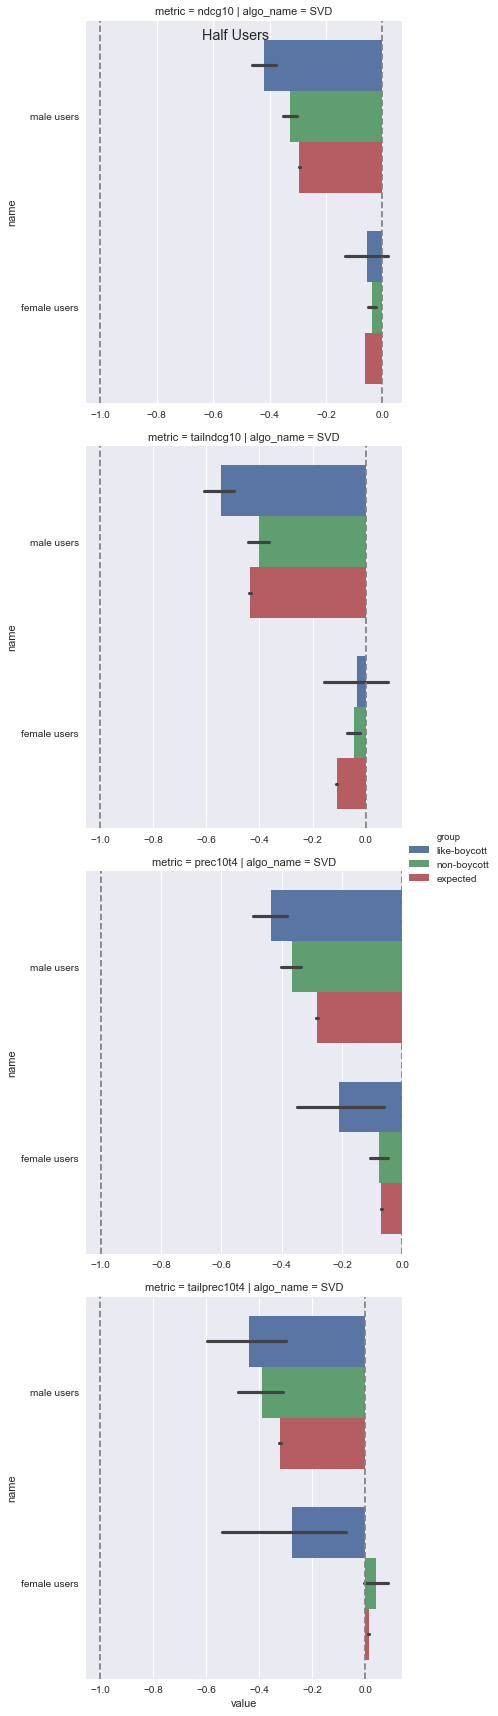

In [819]:
plot_all_three_scenarios(gender_boycotts)

# Power Boycotts

Below, the power boycotts show a very weird results. Warrants double checks.

C:\Users\Nick\Anaconda3\lib\site-packages\pandas\core\computation\expressions.py:179: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


len 40
3434    191328
3437      7229
3440    192854
3443      7187
3446    190898
3449      7252
3452    188158
3455      7205
3458    194239
3461      7174
3464    195489
3467      7192
3470    190566
3473      7184
3476    191985
3479      7225
3482    192569
3485      7233
3488    194146
3491      7266
3493    188359
3495      7244
3497    190197
3499      7205
3501    189059
3503      7229
3505    191050
3507      7175
3509    184196
3511      7234
3513    187146
3515      7222
3517    184177
3519      7168
3521    188490
3523      7244
3525    192686
3527      7229
3529    189169
3531      7167
Name: num_ratings_missing, dtype: int64


C:\Users\Nick\Anaconda3\lib\site-packages\seaborn\categorical.py:1468: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


**
ndcg10 SVD Bottom 10% contributors, percent_increase_ndcg10_expected, percent_increase_ndcg10_non-boycott
Ratio: 4.259961320571024, pval: 1.2246056103574844e-07
==
**
ndcg10 SVD Top 10% contributors, percent_increase_ndcg10_expected, percent_increase_ndcg10_non-boycott
Ratio: 1.6680177256612614, pval: 1.4057998102254406e-07
==
**
tailndcg10 SVD Top 10% contributors, percent_increase_tailndcg10_expected, percent_increase_tailndcg10_non-boycott
Ratio: 1.7911374842441172, pval: 9.590983538834778e-11
==
**
prec10t4 SVD Top 10% contributors, percent_increase_prec10t4_expected, percent_increase_prec10t4_non-boycott
Ratio: 2.0584222595666257, pval: 4.458054012411609e-09
==
**
tailprec10t4 SVD Top 10% contributors, percent_increase_tailprec10t4_expected, percent_increase_tailprec10t4_non-boycott
Ratio: 2.9601935599059184, pval: 3.7859828900919526e-05
==
5 sig, 0 less, and 5 more out of 8 total


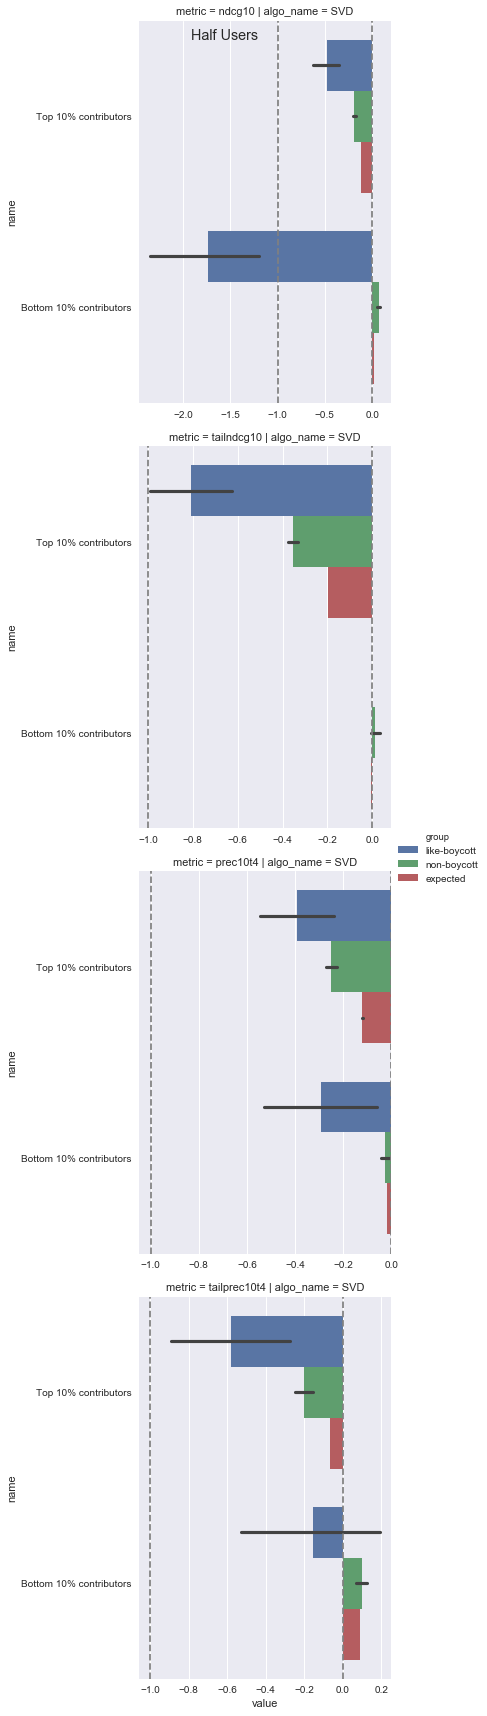

In [820]:
plot_all_three_scenarios(power_boycotts)

C:\Users\Nick\Anaconda3\lib\site-packages\pandas\core\computation\expressions.py:179: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


len 140
2       13590
5       88967
8      196563
11     102846
14      41444
17      34008
20      18311
23      12250
26      89927
29     205078
32     104179
35      45387
38      36139
41      20541
44      14962
47      95194
50     194983
53     100927
56      43613
59      36005
62      22022
65      14370
68      96277
71     198913
74      96193
77      44360
80      39015
83      20217
86      13524
89      95785
        ...  
291     35443
293     20462
295     13862
297     91280
299    199281
301    102984
303     40316
305     32764
307     18620
309     14097
311     88795
313    198296
315    100138
317     40766
319     40181
321     20841
323     13910
325     98660
327    196655
329     96359
331     40613
333     37757
335     20106
337     15298
339     90837
341    204206
343     91133
345     40431
347     35547
349     19871
Name: num_ratings_missing, Length: 140, dtype: int64


C:\Users\Nick\Anaconda3\lib\site-packages\seaborn\categorical.py:1468: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


**
ndcg10 SVD 56+, percent_increase_ndcg10_expected, percent_increase_ndcg10_non-boycott
Ratio: 3.9722708114286327, pval: 6.125180052949222e-05
==
**
ndcg10 SVD 45-49, percent_increase_ndcg10_expected, percent_increase_ndcg10_non-boycott
Ratio: -2.030481303991675, pval: 0.04613104478287376
==
**
tailndcg10 SVD 56+, percent_increase_tailndcg10_expected, percent_increase_tailndcg10_non-boycott
Ratio: -1.027277785669234, pval: 0.005524009921814994
==
**
tailndcg10 SVD 18-24, percent_increase_tailndcg10_expected, percent_increase_tailndcg10_non-boycott
Ratio: 1.4269935329432206, pval: 0.009726254401425946
==
**
tailndcg10 SVD 45-49, percent_increase_tailndcg10_expected, percent_increase_tailndcg10_non-boycott
Ratio: 0.2715140730587764, pval: 0.03111876409828598
==
**
tailprec10t4 SVD 45-49, percent_increase_tailprec10t4_expected, percent_increase_tailprec10t4_non-boycott
Ratio: 1.9892422765251871, pval: 0.009813206451036878
==
6 sig, 3 less, and 3 more out of 28 total


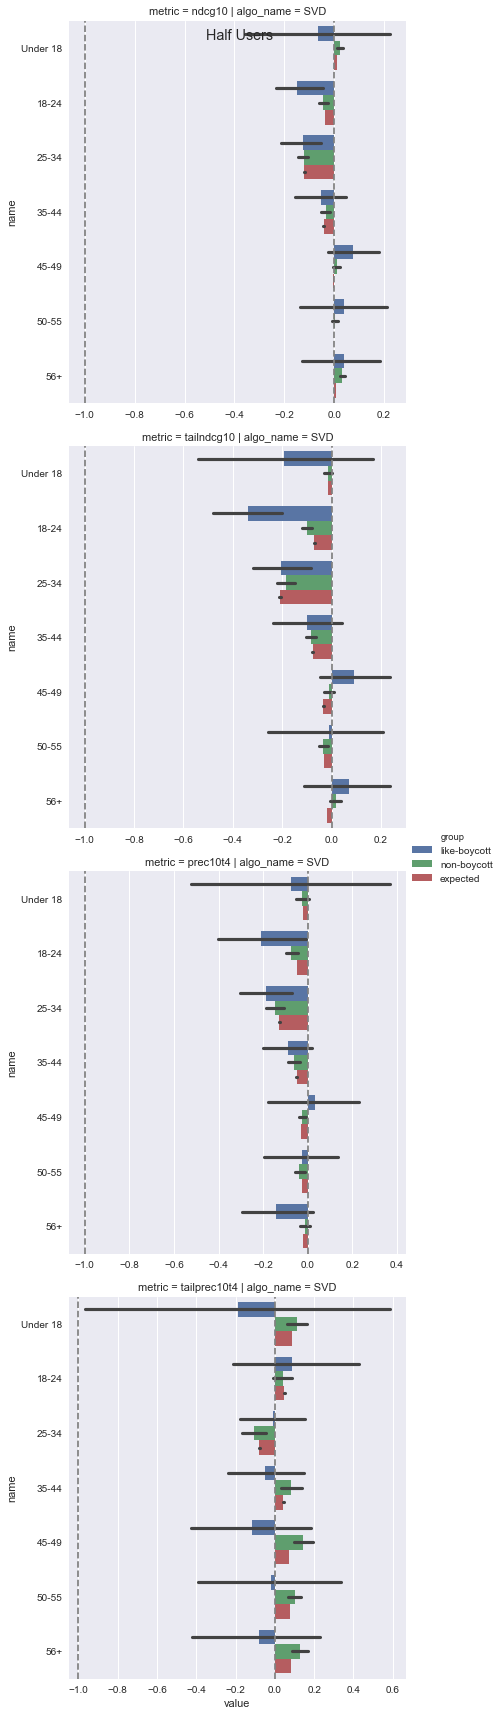

In [821]:
plot_all_three_scenarios(age_boycotts)

C:\Users\Nick\Anaconda3\lib\site-packages\pandas\core\computation\expressions.py:179: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


len 420
2342    65726
2345    39153
2348    25174
2351    14889
2354    66323
2357     8391
2360    17230
2363    47341
2366     1309
2369     5280
2372    10804
2375     9444
2378    29707
2381     7857
2384    27125
2387     9877
2390    22510
2393    35249
2396     4702
2399     7406
2402    32166
2405    61754
2408    41414
2411    24704
2414    15173
2417    69049
2420    11058
2423    18651
2426    53711
2429     1699
        ...  
3331    26137
3333     7225
3335    27733
3337    10568
3339    21390
3341    36495
3343     6483
3345     8000
3347    26929
3349    67874
3351    39199
3353    24282
3355    14991
3357    62999
3359     9206
3361    15483
3363    51642
3365      530
3367     6312
3369    11262
3371     9460
3373    27467
3375     6161
3377    21705
3379    11377
3381    23200
3383    35667
3385     5934
3387     8873
3389    30658
Name: num_ratings_missing, Length: 420, dtype: int64


C:\Users\Nick\Anaconda3\lib\site-packages\seaborn\categorical.py:1468: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


**
ndcg10 SVD homemaker, percent_increase_ndcg10_expected, percent_increase_ndcg10_non-boycott
Ratio: 2.451442262921653, pval: 0.026250232652880033
==
**
tailndcg10 SVD lawyer, percent_increase_tailndcg10_expected, percent_increase_tailndcg10_non-boycott
Ratio: -2.232982216027384, pval: 0.0016109330244113308
==
**
tailndcg10 SVD sales/marketing, percent_increase_tailndcg10_expected, percent_increase_tailndcg10_non-boycott
Ratio: -0.8624826144991711, pval: 0.003115321257346114
==
**
tailndcg10 SVD customer service, percent_increase_tailndcg10_expected, percent_increase_tailndcg10_non-boycott
Ratio: -1.8129720532673812, pval: 0.002631596358442021
==
**
tailndcg10 SVD retired, percent_increase_tailndcg10_expected, percent_increase_tailndcg10_non-boycott
Ratio: -2.5511264482941787, pval: 0.01458517675791081
==
**
tailndcg10 SVD homemaker, percent_increase_tailndcg10_expected, percent_increase_tailndcg10_non-boycott
Ratio: -2.449882108389037, pval: 0.023083727707500994
==
**
prec10t4 SVD cl

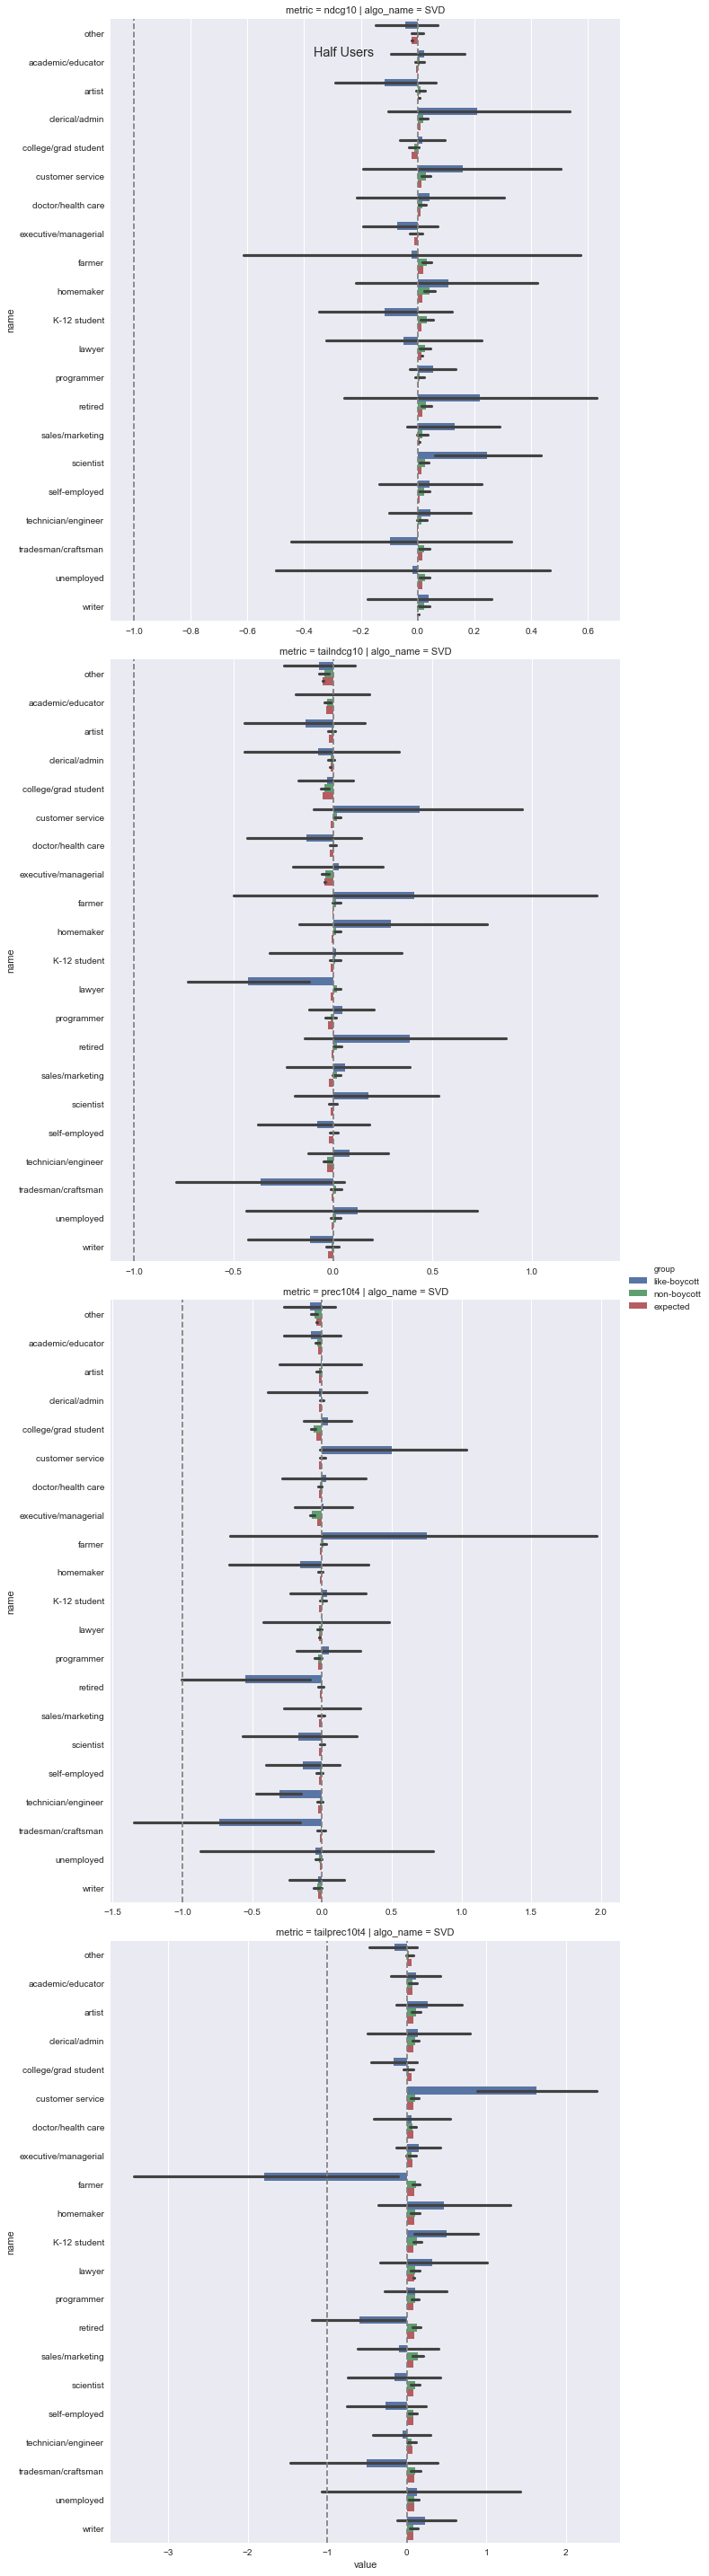

In [822]:
plot_all_three_scenarios(occupation_boycotts, size=10)

C:\Users\Nick\Anaconda3\lib\site-packages\pandas\core\computation\expressions.py:179: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


len 360
1406    140859
1409     59775
1412     41452
1415     63030
1418     75458
1421     47931
1424    132165
1427     80422
1430     61294
1433     50178
1436     87940
1439     70371
1442     64358
1445     21708
1448     56292
1451     21590
1454     21102
1457     27261
1460    143317
1463     58932
1466     40644
1469     56319
1472     77940
1475     51450
1478    133802
1481     87351
1484     58690
1487     52020
1490     93235
1493     75678
         ...  
2245    131661
2247     79868
2249     60848
2251     52881
2253     90728
2255     78489
2257     61839
2259     23822
2261     52957
2263     26346
2265     20936
2267     26531
2269    146469
2271     64536
2273     40813
2275     60525
2277     75135
2279     52341
2281    132087
2283     85034
2285     60994
2287     51985
2289     90193
2291     77679
2293     61937
2295     21271
2297     55661
2299     25741
2301     21768
2303     26474
Name: num_ratings_missing, Length: 360, dtype: int64


C:\Users\Nick\Anaconda3\lib\site-packages\seaborn\categorical.py:1468: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


**
ndcg10 SVD Fans of Documentary  using threshold 4, percent_increase_ndcg10_expected, percent_increase_ndcg10_non-boycott
Ratio: -0.9201731580150118, pval: 0.04674574819111797
==
**
ndcg10 SVD Fans of Children's  using threshold 4, percent_increase_ndcg10_expected, percent_increase_ndcg10_non-boycott
Ratio: 4.262563366911281, pval: 0.012153942385504834
==
**
ndcg10 SVD Fans of Western  using threshold 4, percent_increase_ndcg10_expected, percent_increase_ndcg10_non-boycott
Ratio: -2.15502110283471, pval: 0.03952275539338949
==
**
ndcg10 SVD Fans of Film-Noir  using threshold 4, percent_increase_ndcg10_expected, percent_increase_ndcg10_non-boycott
Ratio: 2.8886109832011884, pval: 4.952528264524777e-05
==
**
ndcg10 SVD Fans of Drama  using threshold 4, percent_increase_ndcg10_expected, percent_increase_ndcg10_non-boycott
Ratio: 0.6499667146093588, pval: 0.006234160548916943
==
**
tailndcg10 SVD Fans of Adventure  using threshold 4, percent_increase_tailndcg10_expected, percent_increase

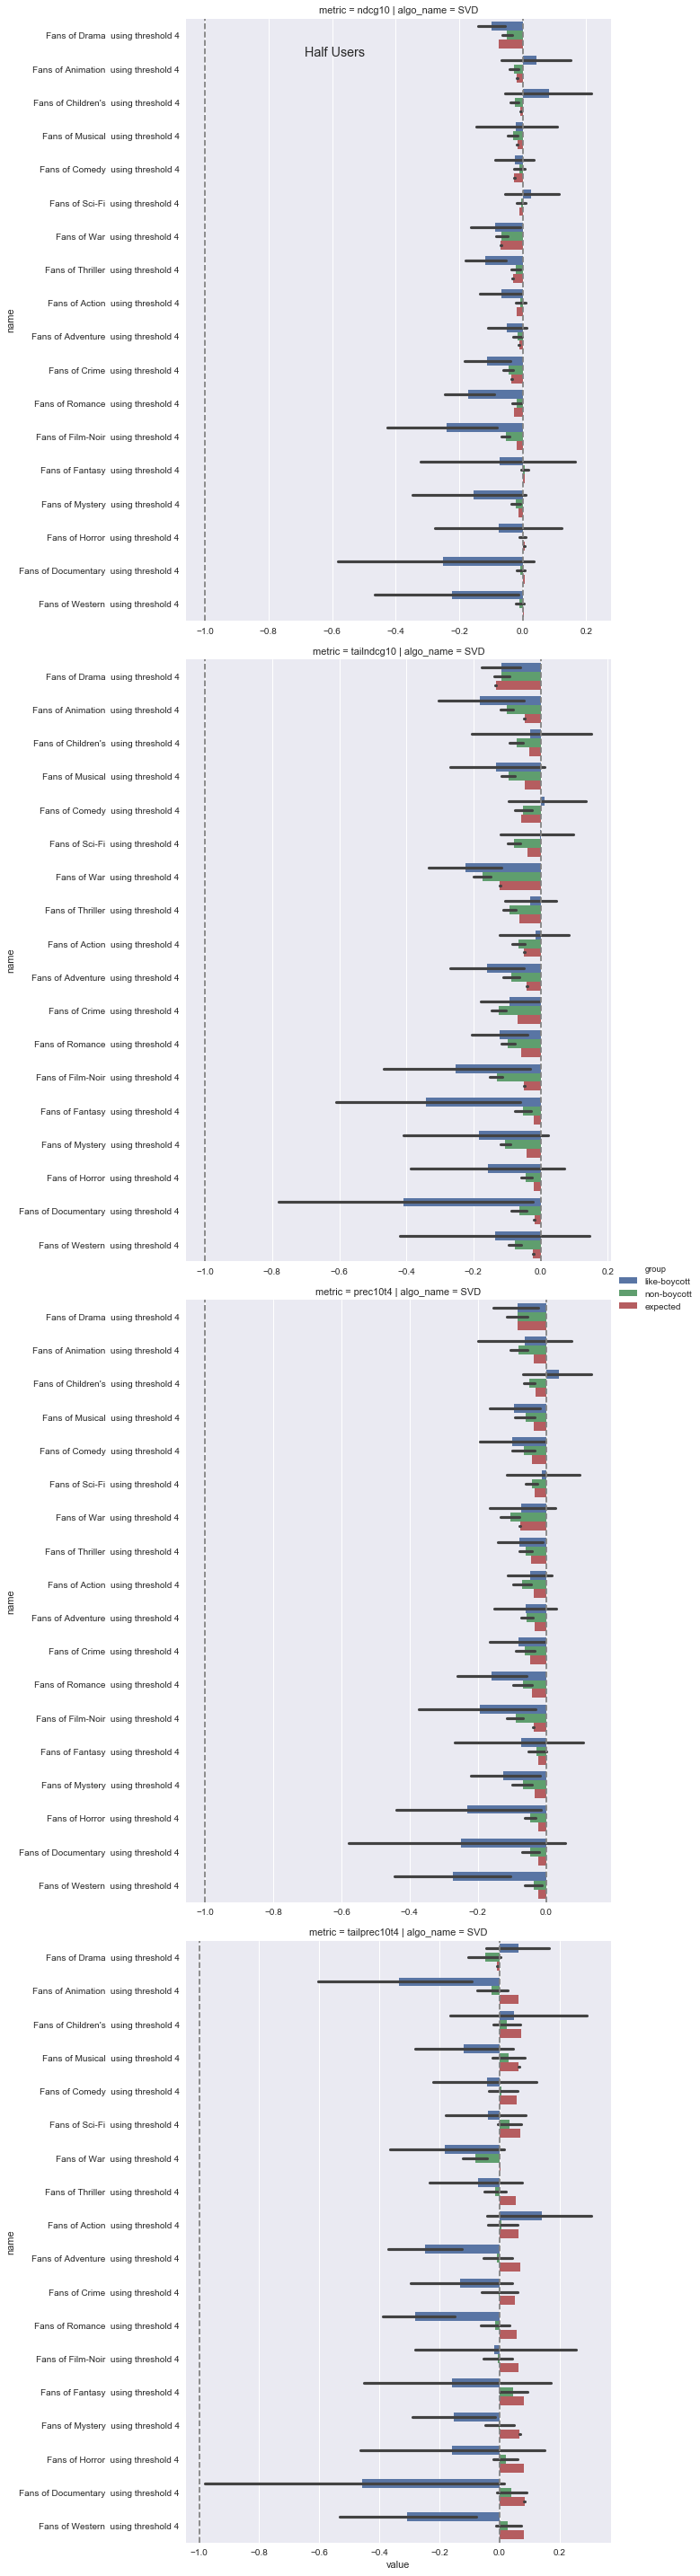

In [823]:
plot_all_three_scenarios(genre_boycotts, size=10)